# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl
import pypoman

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import *
from polytope_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "General_Polytope"

In [2]:
seed_ = np.random.randint(500000)
print(seed_)
np.random.seed(seed_)

136068


# Source Generation and Mixing Scenario

In [3]:
dim = 5
N = 500000
NumberofSources = dim
NumberofMixtures = 10

signed_dims = np.array([0, 1, 3])
nn_dims = np.array([2, 4])
sparse_dims_list = [np.array([0, 1, 4]), np.array([1, 2, 3])]
(Apoly, bpoly), Verts_poly = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)

print(Apoly.shape, bpoly.shape)
Apoly, bpoly = pypoman.compute_polytope_halfspaces(Verts_poly.T)
print(Apoly.shape, bpoly.shape)
S = generate_uniform_points_in_polytope(Verts_poly, N)

(26, 5) (26,)
(10, 5) (10,)


Text(0.5, 0.98, 'Scatter Plot of Source Components')

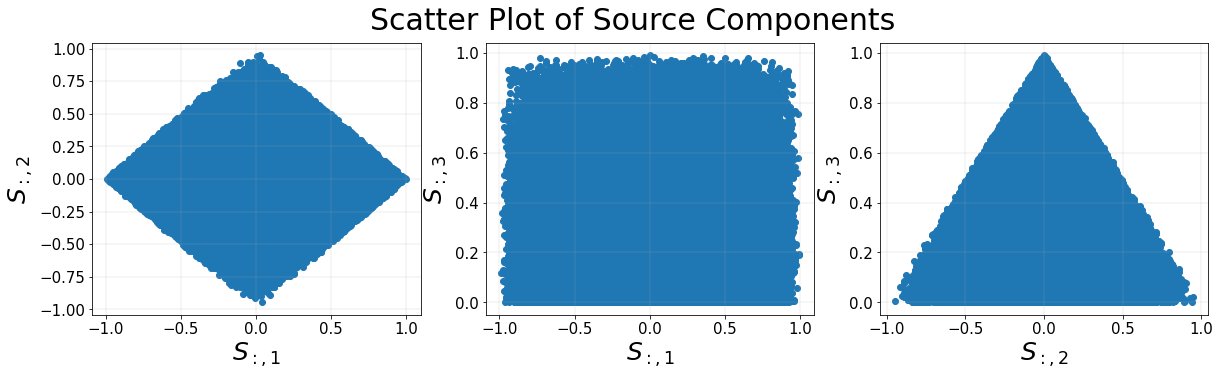

In [4]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(S[0, :], S[1, :])
plt.xlabel("$S_{:,1}$", fontsize=25)
plt.ylabel("$S_{:,2}$", fontsize=25)
plt.grid(linewidth=0.2)
plt.subplot(1, 3, 2)
plt.scatter(S[0, :], S[2, :])
plt.xlabel("$S_{:,1}$", fontsize=25)
plt.ylabel("$S_{:,3}$", fontsize=25)
plt.grid(linewidth=0.2)
plt.subplot(1, 3, 3)
plt.scatter(S[1, :], S[2, :])
plt.xlabel("$S_{:,2}$", fontsize=25)
plt.ylabel("$S_{:,3}$", fontsize=25)
plt.grid(linewidth=0.2)

plt.suptitle("Scatter Plot of Source Components", fontsize=30)
# plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 1200)

In [5]:
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures, NumberofSources)
X = np.dot(A, S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.002628271085285


# Visualize Generated Sources and Mixtures

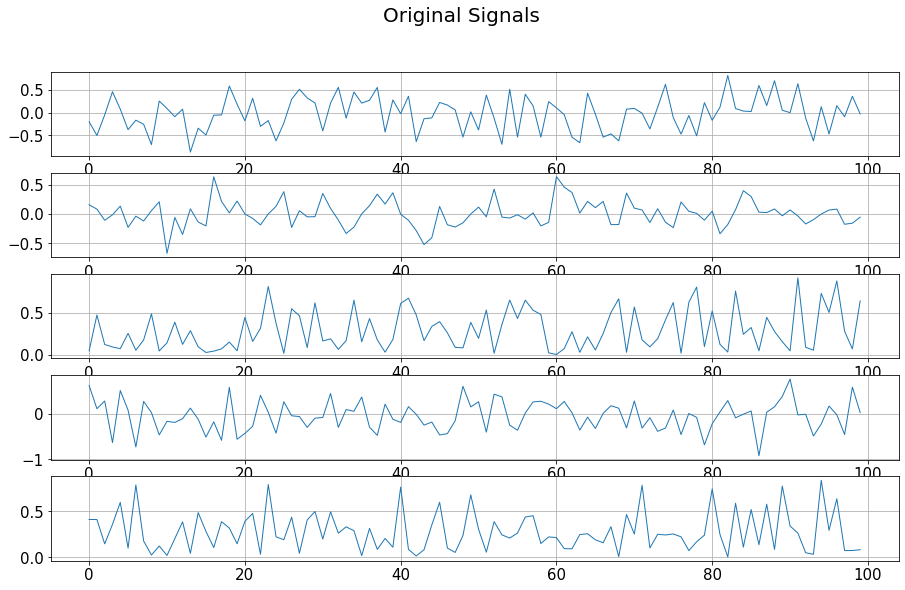

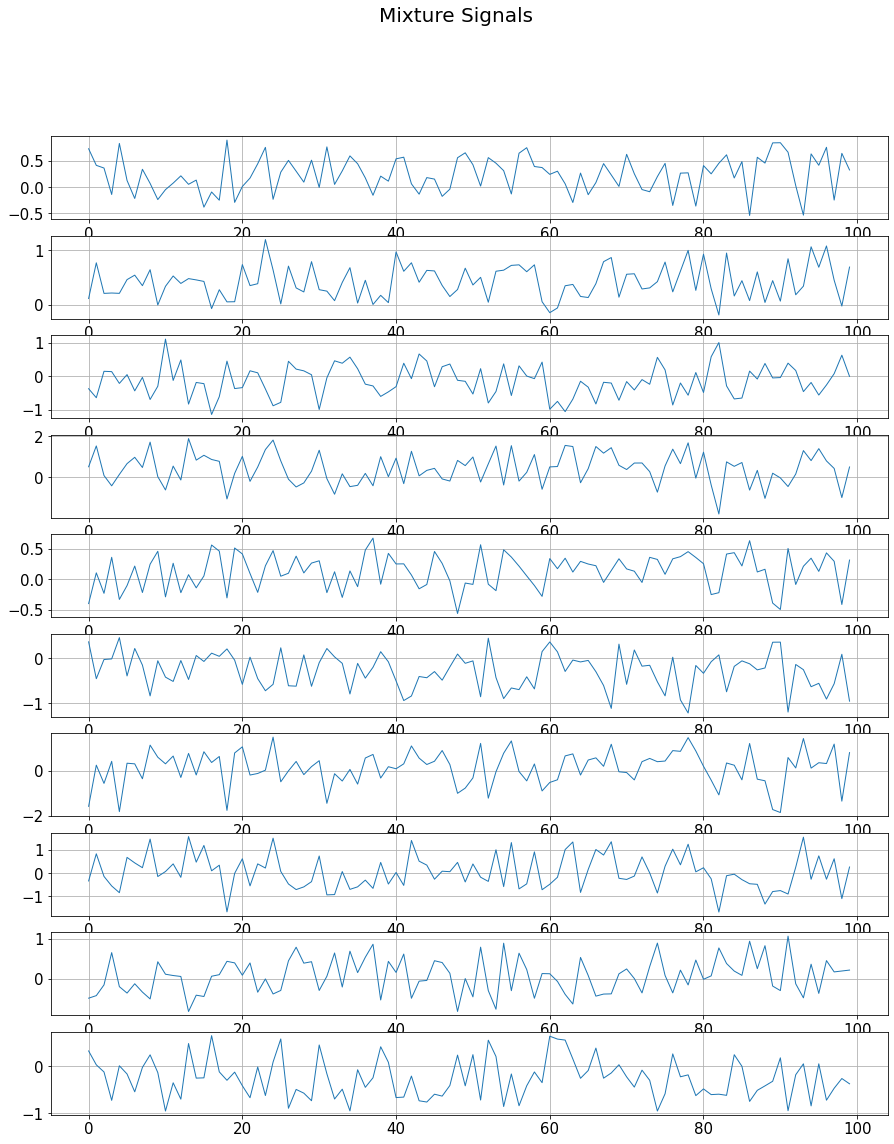

In [6]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [7]:
lambday = 1 - 1e-1 / 10
lambdae = 1 - 1e-1 / 10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 2000 * np.eye(s_dim)

debug_iteration_point = 5000
model = OnlineCorInfoMaxCanonical(
    s_dim=s_dim,
    x_dim=x_dim,
    muW=50 * 1e-3,
    lambday=lambday,
    lambdae=lambdae,
    By=By,
    Be=Be,
    neural_OUTPUT_COMP_TOL=1e-6,
    set_ground_truth=True,
    S=S,
    A=A,
)

# Run CorInfoMax Algorithm on Mixture Signals

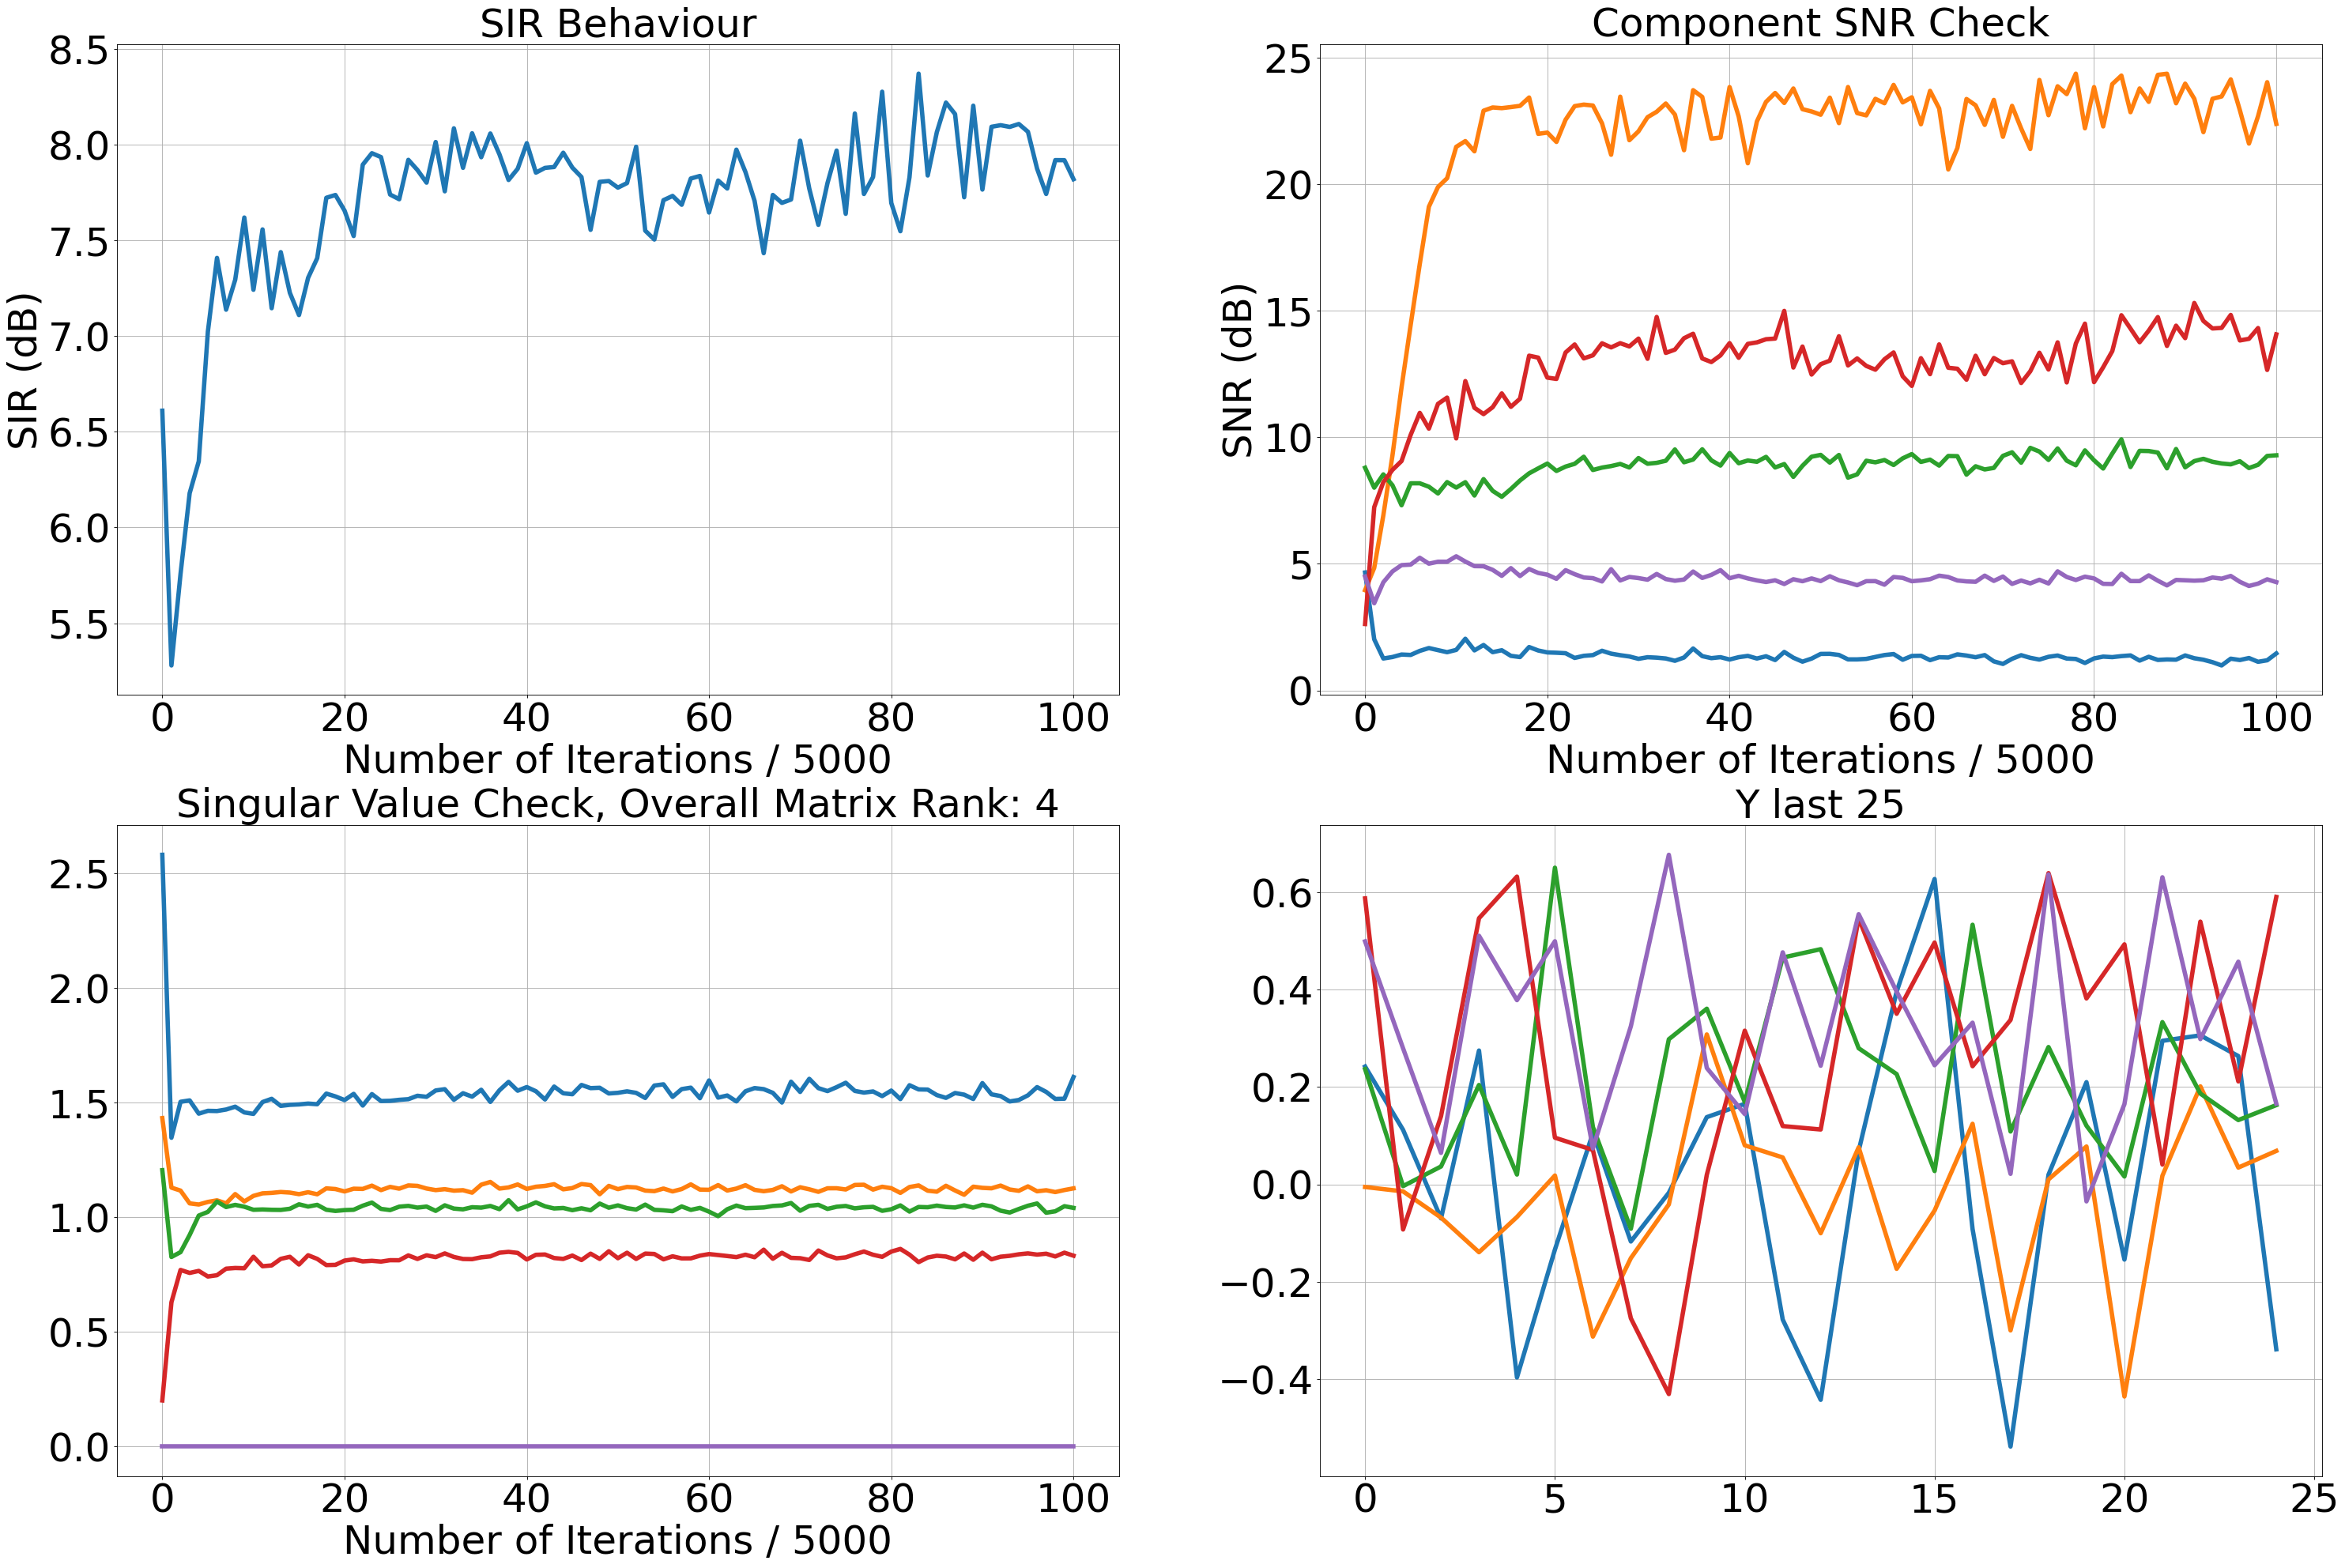

100%|██████████| 500000/500000 [19:14<00:00, 433.22it/s] 


Algorithm took 1154.366534 sec.


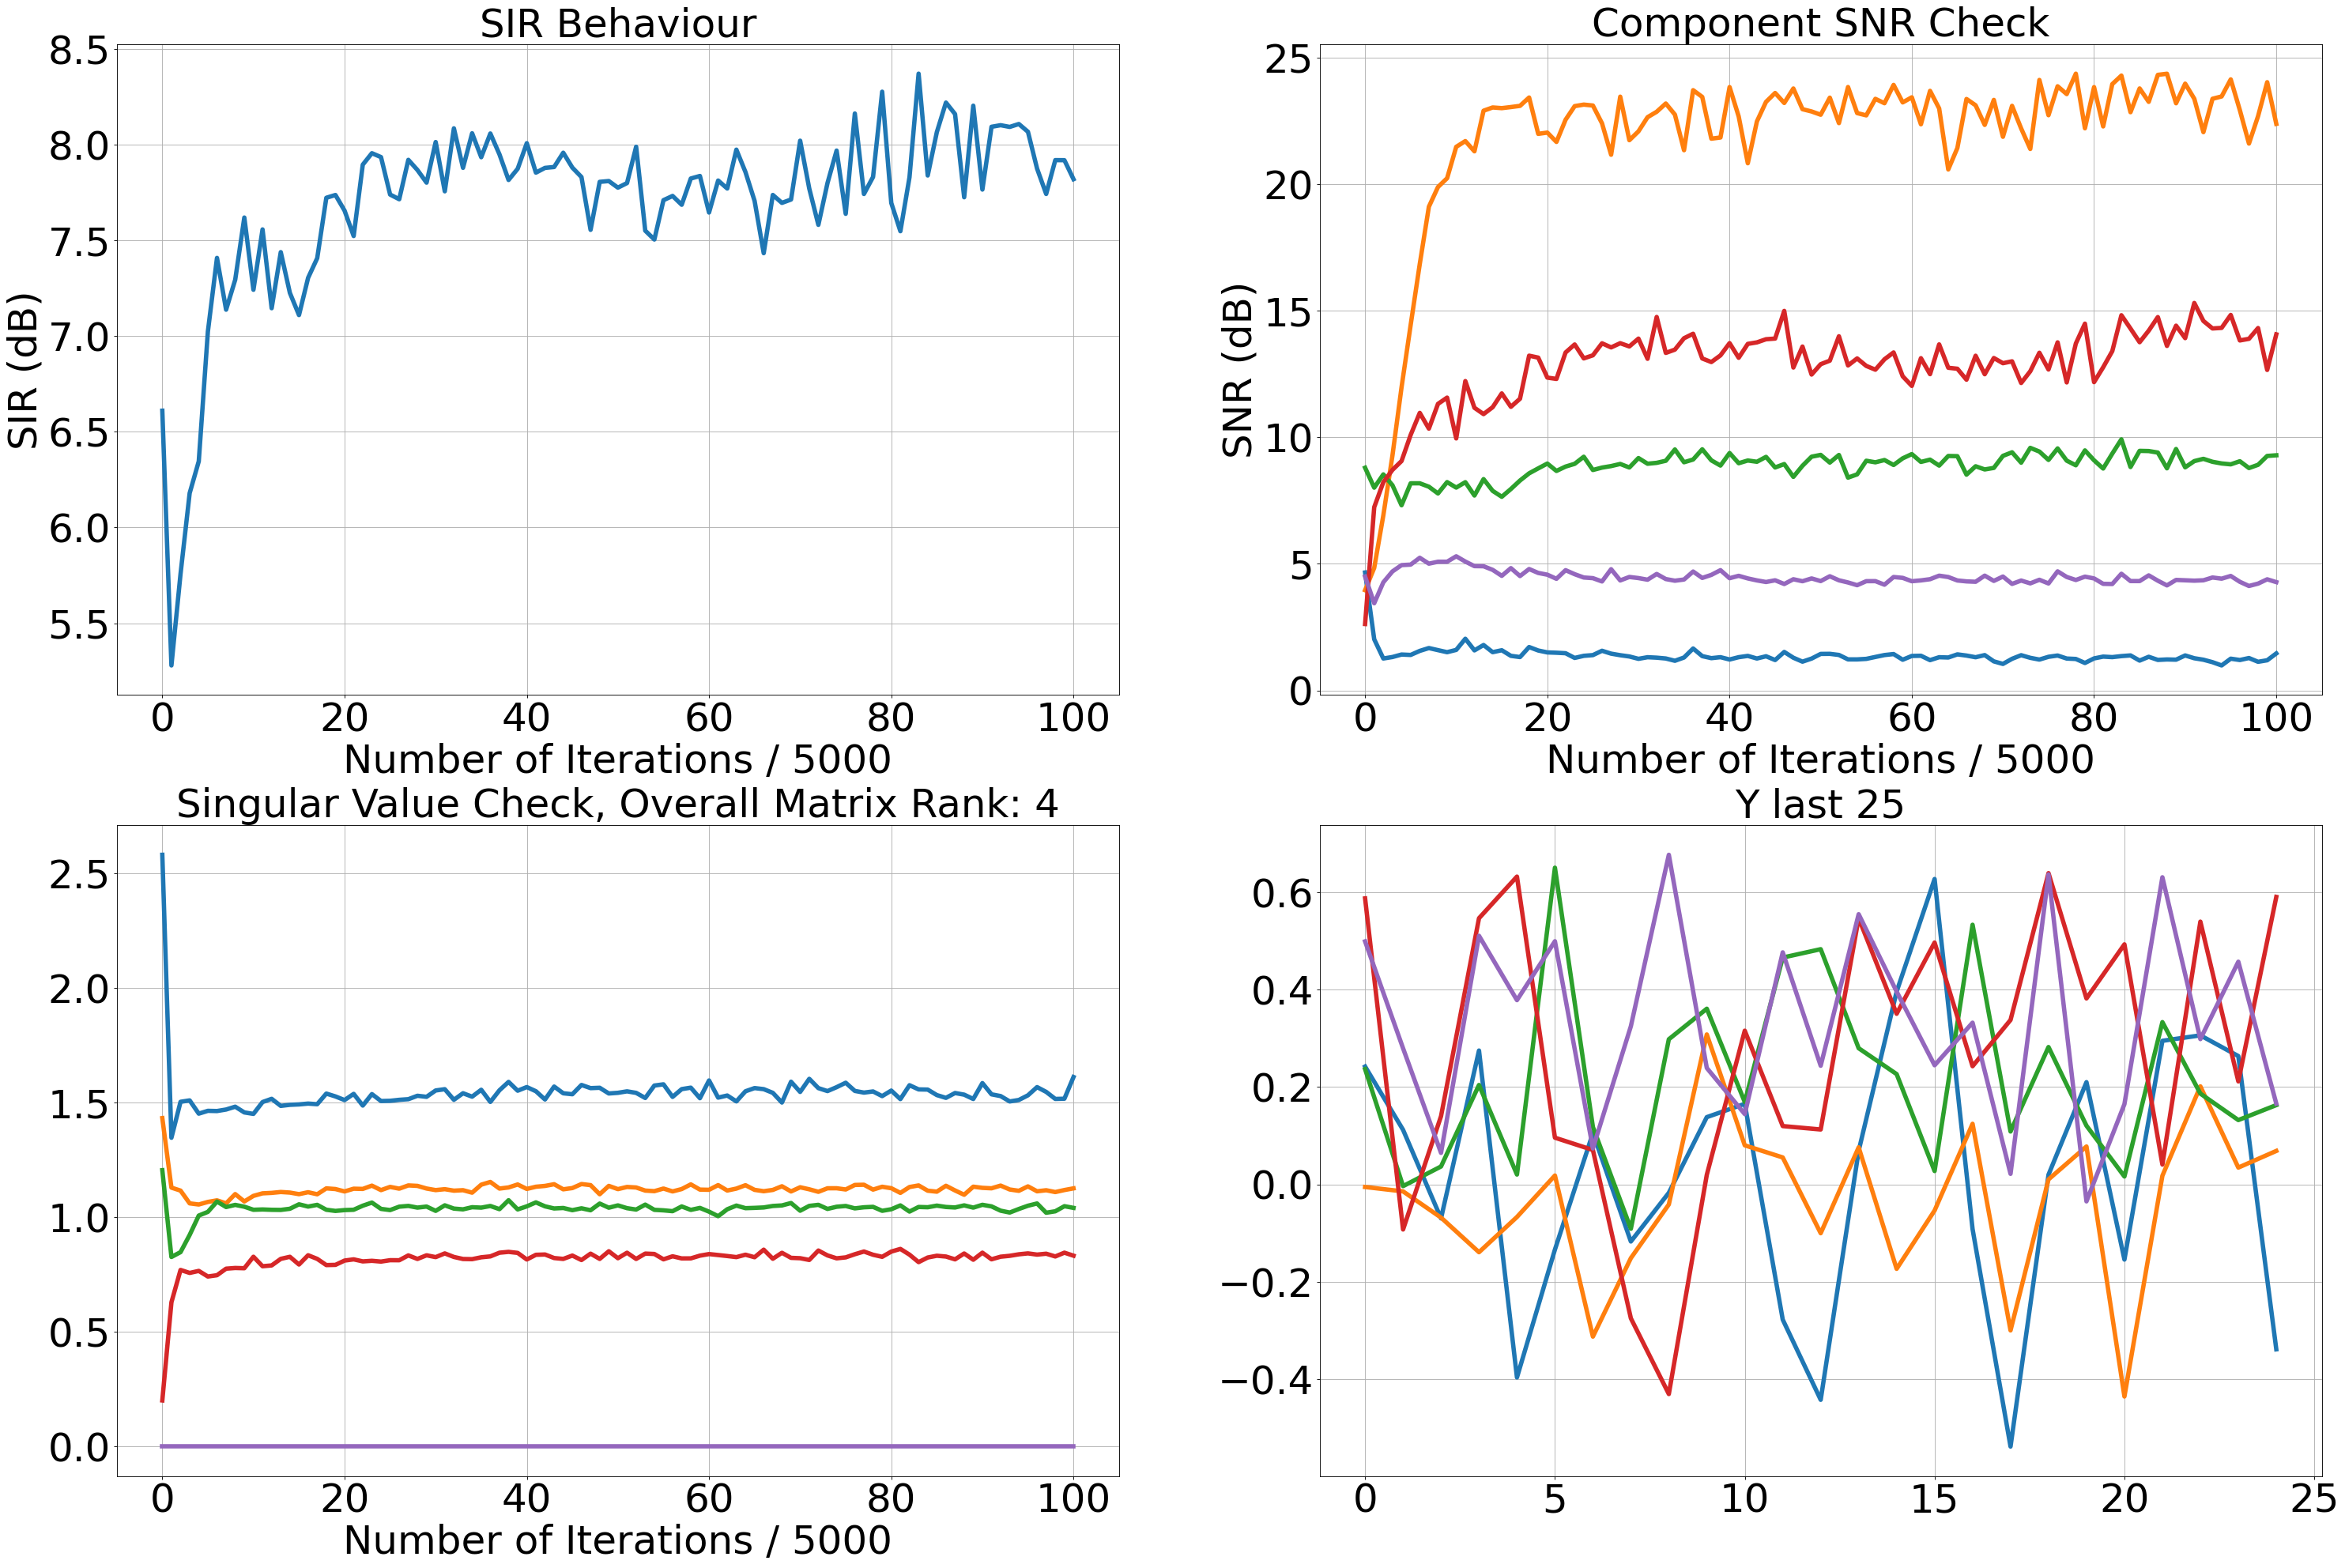

In [8]:
with Timer() as t:
    model.fit_batch(
        X=X,
        Apoly = Apoly,
        bpoly = bpoly,
        n_epochs=1,
        neural_dynamic_iterations=500,
        plot_in_jupyter=True,
        neural_lr_start=0.5, 
        neural_lr_stop=1e-4,
        debug_iteration_point=debug_iteration_point,
        shuffle=False,
    )
print("Algorithm took %f sec." % (t.interval))

In [9]:
np.linalg.cond(A)

4.487690887665523

# Visualize SINR Convergence 

Final SIR: 7.820424720050932


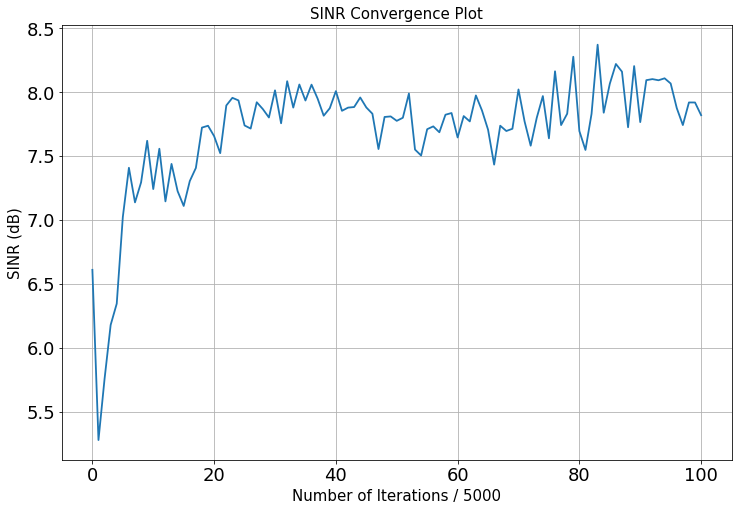

In [10]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    model.SIR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

print("Final SIR: {}".format(np.array(model.SIR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [11]:
Szeromean = S - S.mean(axis=1).reshape(-1, 1)
Wf = model.compute_overall_mapping(return_mapping=True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis=1).reshape(-1, 1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean, Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, Szeromean, False)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [ 1.82373076 22.77088383  4.79966844 14.07691308  2.94581322]

Overall SINR : 5.917197882806534


In [12]:
from bss_utils import *
WfCorInfoMax = model.compute_overall_mapping(return_mapping = True)
YCorInfoMax = WfCorInfoMax @ X
SINRCorInfoMax, SNRCorInfoMax, _, _, _ = evaluate_bss(WfCorInfoMax, YCorInfoMax, A, S, mean_normalize_estimations = False)
SINRCorInfoMax

7.820424720050932

# Vizualize Extracted Signals Compared to Original Sources

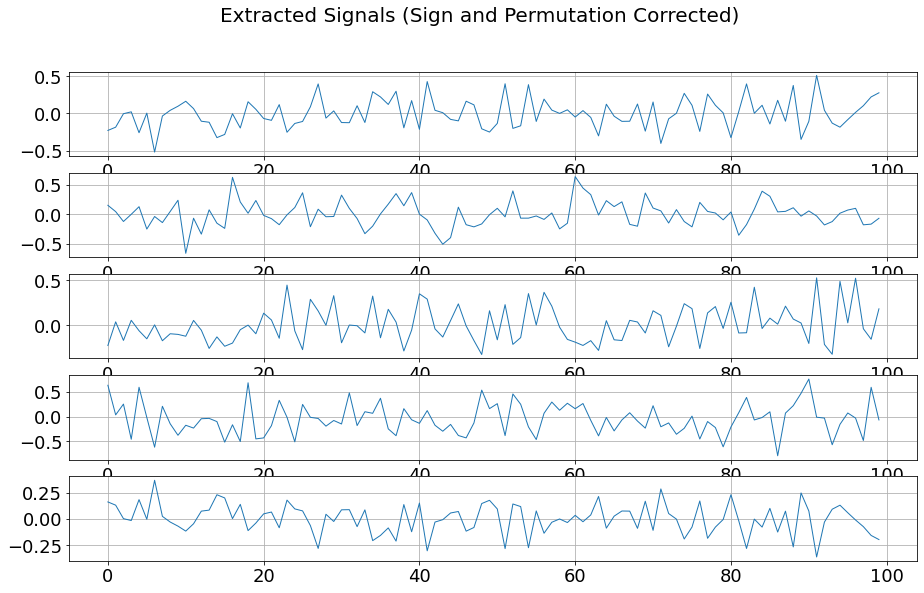

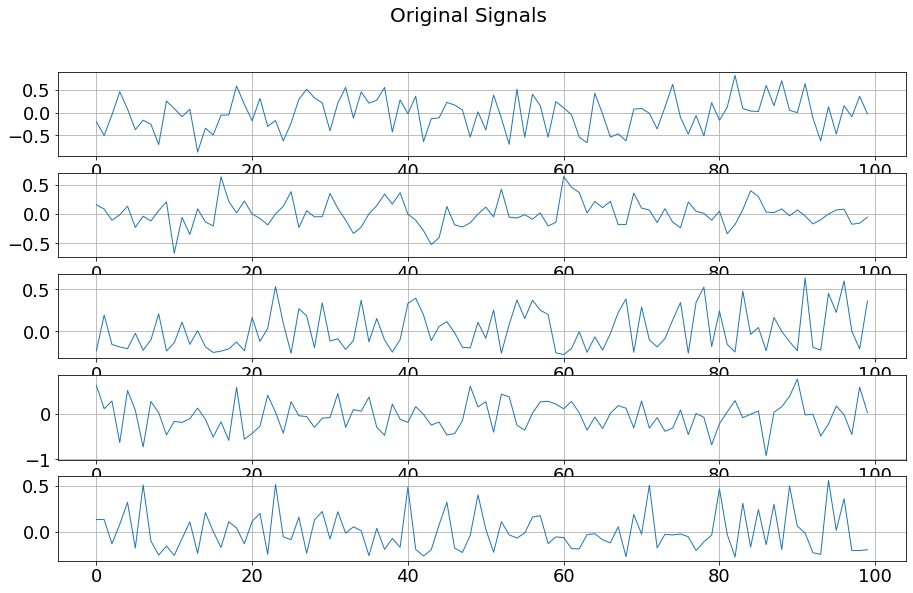

In [13]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    Szeromean[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)